In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from numpy.random import seed
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.utils import plot_model

%matplotlib inline


Using TensorFlow backend.


In [2]:
test_size = 0.2  #propotion for test set
cv_size = 0.2   #proportion for cross validation

N = 9 # for feature at day t, we use lags from t-1, t-2, ..., t-N as features. 

In [3]:
# Initial params
lstm_units=50                  
dropout_prob=1                
optimizer='adam'               
epochs=1                      
batch_size=1

model_seed = 100

seed(101)
set_random_seed(model_seed)

In [4]:
def get_mape(y_true, y_pred):
    
    #Compute mean absolute percentage error (MAPE) 
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def getxy(data, N, offset):
    
    # Divid data into x features and y targets
    x,y = [], []
    
    for i in range(offset, len(data)):
        x.append(data[i-N:i])
        y.append(data[i])
    x = np.array(x)
    y = np.array(y)
    
    return x, y

def get_scaled_x_y(data, N, offset):
    
    # Divid data into x features and y targets, and scaling x using std
    # mu_list : list of means
    # std_list : list of std devs
    
    x_scaled, y, mu_list, std_list = [], [], [], []
    
    for i in range(offset, len(data)):
        mu_list.append(np.mean(data[i-N:i]))
        std_list.append(np.std(data[i-N:i]))
        x_scaled.append(data[i-N:i]-mu_list[i-offset]/std_list[i-offset])
        y.append(data[i])
    x_scaled = np.array(x_scaled)
    y = np.array(y)
    
    return x_scaled, y, mu_list, std_list

def train_pred_eval_model(x_train_scaled, \
                          y_train_scaled, \
                          x_cv_scaled, \
                          y_cv, \
                          mu_cv_list, \
                          std_cv_list, \
                          lstm_units = 50, \
                          dropout_prob = 0.5, \
                          optimizer = 'adam', \
                          epochs = 1, \
                          batch_size = 1):

    # Init the LSTM model
    model = Sequential()
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
    model.add(Dropout(dropout_prob))
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_prob))
    model.add(Dense(1))
    
    
    #Compile and fit the LSTM
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=0)
    
    
    # Predicting
    est_scaled = model.predict(x_cv_scaled)
    est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
    
    #RMSE and MAPE
    
    rmse = math.sqrt(mean_squared_error(y_cv, est))
    mape = get_mape(y_cv, est)
    
    return rmse, mape, est


In [5]:
df = pd.read_csv('./closeframe2.csv')

# convert the index type to datetime type
df.loc[:,'Date'] = pd.to_datetime(df['Date'])

df.head()

,Date,3PL,8IH,AAA,AAC,AAD,ABC,ABP,ABX,ACL,...,XTE,XTJ,XTL,XTO,XUJ,XXJ,YAL,YBR,YOW,ZIP
0,2015-01-02,2.26,0.340,50.11,1.47,2.90,3.63,3.05,0.300,0.092,...,0.45,2086.9,3409.9,4532.0,5936.5,7299.7,0.135,0.60,0.545,0.270
1,2015-01-05,2.07,0.335,50.11,1.48,2.82,3.65,3.10,0.290,0.091,...,0.45,2088.6,3412.4,4543.5,6041.9,7304.4,0.135,0.59,0.540,0.280
2,2015-01-06,2.08,0.335,50.11,1.46,2.70,3.60,3.10,0.295,0.092,...,0.45,2072.7,3357.5,4473.7,5989.8,7220.3,0.135,0.60,0.545,0.280
3,2015-01-07,2.05,0.335,50.12,1.49,2.59,3.60,3.10,0.285,0.092,...,0.45,2075.5,3354.2,4464.5,5957.1,7207.6,0.135,0.60,0.560,0.315
4,2015-01-08,2.08,0.330,50.12,1.51,2.65,3.63,3.14,0.285,0.092,...,0.45,2099.2,3375.1,4488.6,6021.1,7249.3,0.110,0.60,0.545,0.385


Text(0, 0.5, 'Price')

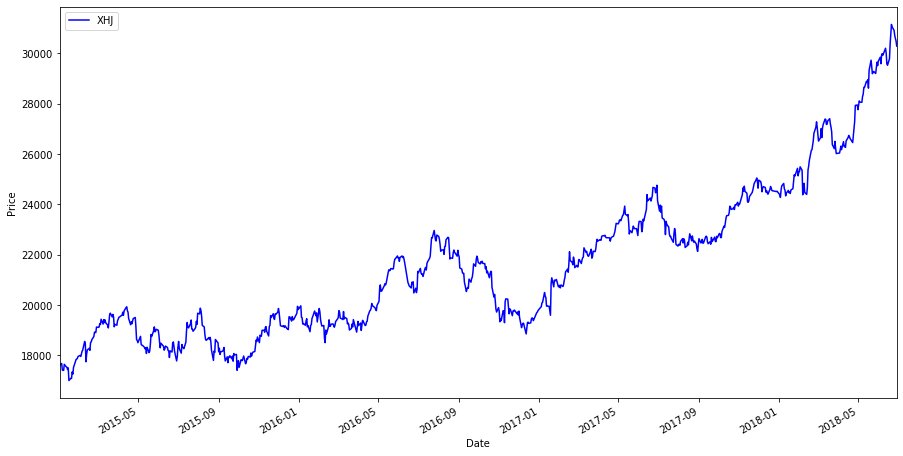

In [6]:
# plot LKO  KCN XHJ
rcParams['figure.figsize'] = 15, 8

ax = df.plot(x='Date', y='XHJ', style='b-')
ax.set_xlabel("Date")
ax.set_ylabel("Price")

In [7]:
# Divid the entire dataset into train, cv and test
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

train = df[:num_train][['Date', 'XHJ']]
cv = df[num_train:num_train+num_cv][['Date', 'XHJ']]
train_cv = df[:num_train+num_cv][['Date', 'XHJ']]
test = df[num_train+num_cv:][['Date', 'XHJ']]

print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 531
num_cv = 176
num_test = 176
train.shape = (531, 2)
cv.shape = (176, 2)
train_cv.shape = (707, 2)
test.shape = (176, 2)


In [8]:
# Divid the dataset into x_train and y_train
scaler = StandardScaler()
train_scaled = scaler.fit_transform(np.array(train['XHJ']).reshape(-1,1))
print("scaler.mean_ = " + str(scaler.mean_))
print("scaler.var_ = " + str(scaler.var_))

x_train_scaled, y_train_scaled = getxy(train_scaled, N, N)
print("x_train_scaled.shape = " + str(x_train_scaled.shape)) # (446, 7, 1)
print("y_train_scaled.shape = " + str(y_train_scaled.shape)) # (446, 1)

scaler.mean_ = [19608.20056497]
scaler.var_ = [1706466.78660985]
x_train_scaled.shape = (522, 9, 1)
y_train_scaled.shape = (522, 1)


In [9]:
# Scale cv dataset
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_scaled_x_y(np.array(train_cv['XHJ']).reshape(-1,1), N, num_train)
print("x_cv_scaled.shape = " + str(x_cv_scaled.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("len(mu_cv_list) = " + str(len(mu_cv_list)))
print("len(std_cv_list) = " + str(len(std_cv_list)))

x_cv_scaled.shape = (176, 9, 1)
y_cv.shape = (176, 1)
len(mu_cv_list) = 176
len(std_cv_list) = 176


In [10]:
# init the LSTM
model = Sequential()
model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(x_train_scaled.shape[1],1)))
model.add(Dropout(dropout_prob))
model.add(LSTM(units=lstm_units))
model.add(Dropout(dropout_prob))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=optimizer)
model.fit(x_train_scaled, y_train_scaled, epochs=epochs, batch_size=batch_size, verbose=2)

W1210 06:17:42.838393  4072 deprecation_wrapper.py:119] From D:\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1210 06:17:42.840392  4072 deprecation_wrapper.py:119] From D:\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1210 06:17:42.842379  4072 deprecation_wrapper.py:119] From D:\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1210 06:17:43.134210  4072 deprecation_wrapper.py:119] From D:\Miniconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1210 06:17:43.276131  4072 deprecation.py:323] From D:\Miniconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250

Epoch 1/1
 - 4s - loss: 0.1240


In [11]:
# Predicting
est_scaled = model.predict(x_cv_scaled)
est = (est_scaled * np.array(std_cv_list).reshape(-1,1)) + np.array(mu_cv_list).reshape(-1,1)
print("est.shape = " + str(est.shape))

# RMSE
rmse_bf_tuning = math.sqrt(mean_squared_error(y_cv, est))
print("RMSE = %0.3f" % rmse_bf_tuning)

# MAPE
mape_bf_tuning = get_mape(y_cv, est)
print("MAPE = %0.3f" % rmse_bf_tuning)


est.shape = (176, 1)
RMSE = 608.394
MAPE = 608.394


Text(0, 0.5, 'Future close return')

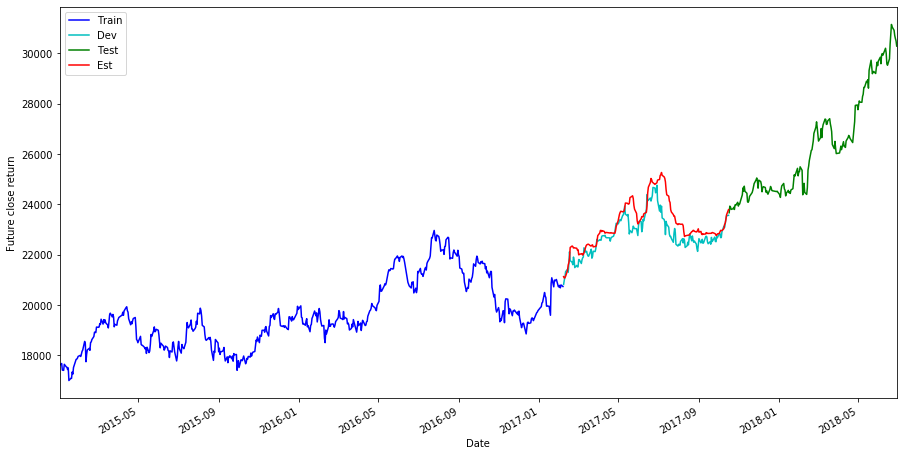

In [12]:
rcParams['figure.figsize'] = 15, 8
est_df = pd.DataFrame({'est': est.reshape(-1),
                       'y_cv': y_cv.reshape(-1),
                       'Date': cv['Date']})

ax = train.plot(x='Date', y='XHJ', style='b-')
ax = cv.plot(x='Date', y='XHJ', style='c-', ax=ax)
ax = test.plot(x='Date', y='XHJ', style='g-', ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', ax=ax )
ax.legend(['Train', 'Dev', 'Test', 'Est'])
ax.set_xlabel("Date")
ax.set_ylabel("Future close return")

In [13]:
# Tuning parameter N
param_label = 'N'
param_list = range(3,60)

error_rate = { param_label : [], 'RMSE' : [], 'MAPE' : []}
for param in tqdm_notebook(param_list):
    x_train_scaled, y_train_scaled = getxy(train_scaled, param, param)
    x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_scaled_x_y(np.array(train_cv['XHJ']).reshape(-1,1), param, num_train)
    rmse, mape, _ = train_pred_eval_model(x_train_scaled, y_train_scaled, x_cv_scaled, y_cv, mu_cv_list, std_cv_list, lstm_units, dropout_prob, optimizer, epochs, batch_size)
    
    error_rate[param_label].append(param)
    error_rate['RMSE'].append(rmse)
    error_rate['MAPE'].append(mape)

error_rate = pd.DataFrame(error_rate)

min RMSE = 413.729
min MAPE = 1.316%
optimum N = 6


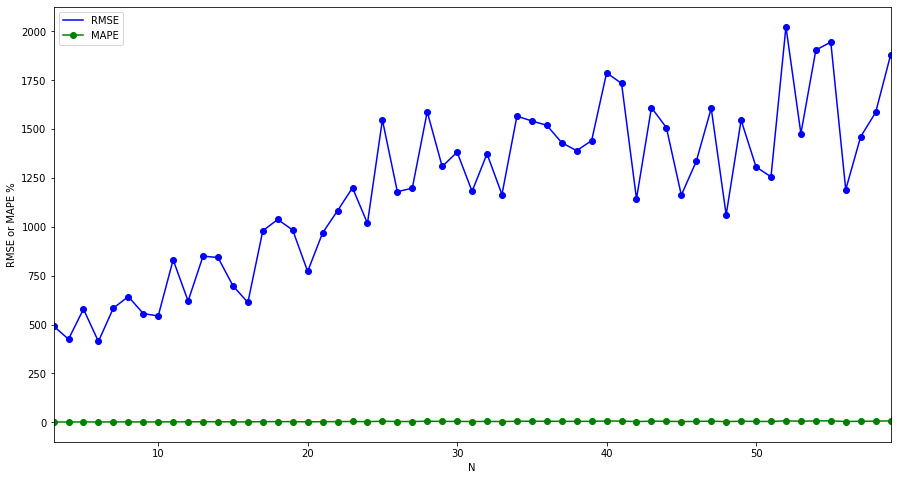

In [14]:
rcParams['figure.figsize'] = 15, 8

ax = error_rate.plot(x='N', y='RMSE', style='bo-')
ax = error_rate.plot(x='N', y='MAPE', style='go-', ax=ax)
ax.set_xlabel("N")
ax.set_ylabel("RMSE or MAPE %")

temp = error_rate[error_rate['RMSE'] == error_rate['RMSE'].min()]
N_param = temp['N'].values[0]
print("min RMSE = %0.3f" % error_rate['RMSE'].min())
print("min MAPE = %0.3f%%" % error_rate['MAPE'].min())
print("optimum " + param_label + " = " + str(N_param))

In [15]:
# Tuning epochs and batch size

param_label = 'epochs'
param_list = [1, 10, 20, 30, 40, 50]

param_label2 = 'batch_size'
param_list2 = [8, 16, 32, 64, 128]

x_train_scaled, y_train_scaled = getxy(train_scaled, N_param, N_param)
x_cv_scaled, y_cv, mu_cv_list, std_cv_list = get_scaled_x_y(np.array(train_cv['XHJ']).reshape(-1,1), N_param, num_train)

error_rate = { param_label : [], param_label2 : [], 'RMSE' : [], 'MAPE' : []}

for param in tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param_list2):
        
        rmse, mape, _= train_pred_eval_model(x_train_scaled, y_train_scaled, x_cv_scaled, y_cv, mu_cv_list, std_cv_list, lstm_units, dropout_prob, optimizer, param, param2)
        error_rate[param_label].append(param)
        error_rate[param_label2].append(param2)
        error_rate['RMSE'].append(rmse)
        error_rate['MAPE'].append(mape)


error_rate = pd.DataFrame(error_rate)
error_rate

,epochs,batch_size,RMSE,MAPE
0,1,8,504.931589,1.657759
1,1,16,551.635938,1.839233
2,1,32,352.072748,1.099352
3,1,64,380.665212,1.194463
4,1,128,288.686092,0.967555
5,10,8,762.722135,2.685248
6,10,16,562.718832,1.882315
7,10,32,562.631573,1.881974
8,10,64,524.437231,1.733530
9,10,128,529.169577,1.751881


Min RMSE = 288.686
Min MAPE = 0.968%
optimum epochs = 1
optimum batch_size = 128


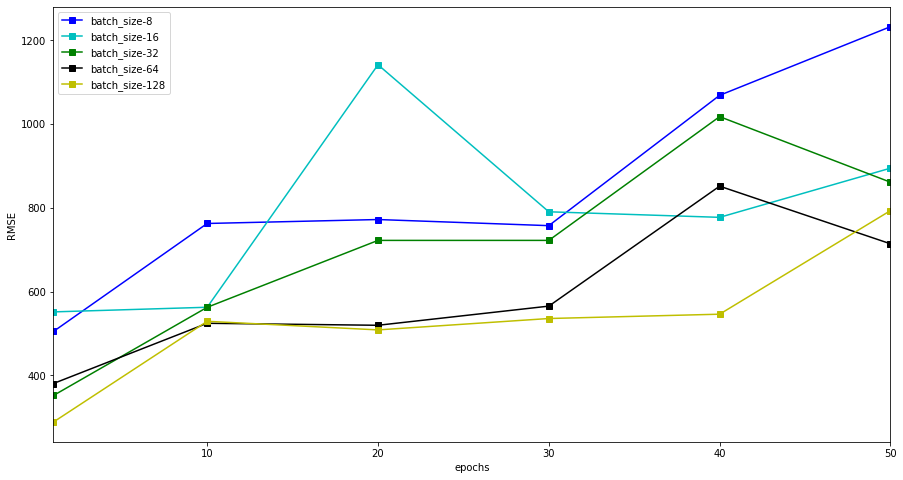

In [16]:
rcParams['figure.figsize'] = 15, 8
temp = error_rate[error_rate[param_label2] == param_list2[0]]
ax = temp.plot(x=param_label, y='RMSE', style='bs-')
legends = [param_label2 + '-' + str(param_list2[0])]
colors = ['r','c','g','k','y','m']

for i in range(1,len(param_list2)):
    temp = error_rate[error_rate[param_label2] == param_list2[i]]
    ax = temp.plot(x=param_label, y='RMSE', color=colors[i%len(colors)], marker='s', ax=ax)
    legends.append(param_label2 + '-' + str(param_list2[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

matplotlib.rcParams.update()
plt.legend(legends)

temp = error_rate[error_rate['RMSE'] == error_rate['RMSE'].min()]
epochs_param = temp[param_label].values[0]
batch_size_param = temp[param_label2].values[0]
print("Min RMSE = %0.3f" % error_rate['RMSE'].min())
print("Min MAPE = %0.3f%%" % error_rate['MAPE'].min())
print("optimum " + param_label + " = " + str(epochs_param))
print("optimum " + param_label2 + " = " + str(batch_size_param))

In [17]:
# Tuning lstm units and dropout prob
param_label = 'lstm-units'
param_list = [10, 50, 64, 128]

param_label2 = 'dropout-prob'
param_list2 = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = { param_label : [], param_label2 : [], 'RMSE' : [], 'MAPE' : []}

for param in tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param_list2):
        
        rmse, mape, _= train_pred_eval_model(x_train_scaled, y_train_scaled, x_cv_scaled, y_cv, mu_cv_list, std_cv_list, lstm_units=param, dropout_prob=param2, optimizer=optimizer, epochs=epochs_param, batch_size=batch_size_param)
        error_rate[param_label].append(param)
        error_rate[param_label2].append(param2)
        error_rate['RMSE'].append(rmse)
        error_rate['MAPE'].append(mape)


error_rate = pd.DataFrame(error_rate)
error_rate

W1210 07:00:48.199305  4072 deprecation.py:506] From D:\Miniconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1210 07:01:29.533615  4072 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1210 07:01:29.658529  4072 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1210 07:02:10.891895  4072 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W1210 07:02:11.017812  4072 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 

,lstm-units,dropout-prob,RMSE,MAPE
0,10,0.5,302.192343,1.036333
1,10,0.6,288.549317,0.978092
2,10,0.7,288.603925,0.967980
3,10,0.8,294.096171,1.006427
4,10,0.9,290.336255,0.989042
5,10,1.0,295.390889,1.011597
6,50,0.5,288.684705,0.979246
7,50,0.6,296.444217,1.015623
8,50,0.7,305.302886,1.047223
9,50,0.8,288.995158,0.966647


Min RMSE = 288.549
Min MAPE = 0.966%
optimum lstm-units = 1
optimum dropout-prob = 128


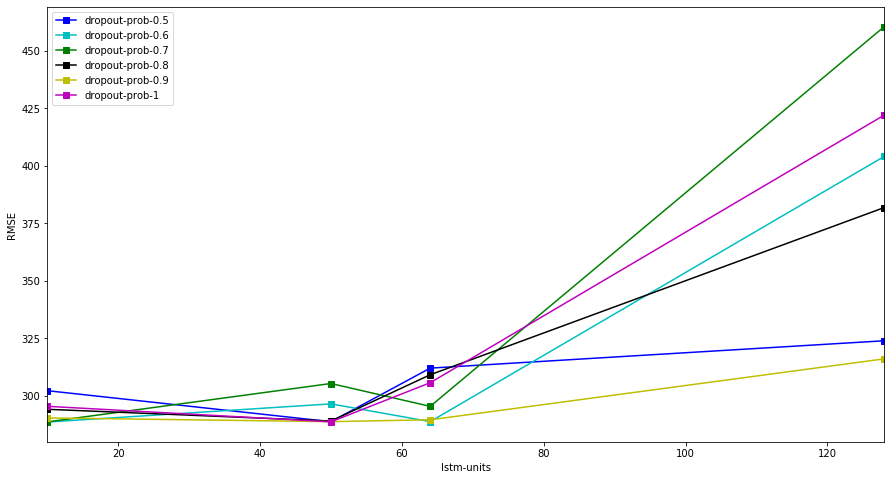

In [18]:
rcParams['figure.figsize'] = 15, 8
temp = error_rate[error_rate[param_label2] == param_list2[0]]
ax = temp.plot(x=param_label, y='RMSE', style='bs-')
legends = [param_label2 + '-' + str(param_list2[0])]
colors = ['r','c','g','k','y','m']

for i in range(1,len(param_list2)):
    temp = error_rate[error_rate[param_label2] == param_list2[i]]
    ax = temp.plot(x=param_label, y='RMSE', color=colors[i%len(colors)], marker='s', ax=ax)
    legends.append(param_label2 + '-' + str(param_list2[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")

matplotlib.rcParams.update()
plt.legend(legends)

temp = error_rate[error_rate['RMSE'] == error_rate['RMSE'].min()]
lstm_units_param = temp[param_label].values[0]
dropout_prob_param = temp[param_label2].values[0]
print("Min RMSE = %0.3f" % error_rate['RMSE'].min())
print("Min MAPE = %0.3f%%" % error_rate['MAPE'].min())
print("optimum " + param_label + " = " + str(epochs_param))
print("optimum " + param_label2 + " = " + str(batch_size_param))

In [19]:
#Tuning optimizer
param_label = 'optimizer'
param_list = ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'adamax', 'nadam']


error_rate = { param_label : [],  'RMSE' : [], 'MAPE' : []}

for param in tqdm_notebook(param_list):     
    rmse, mape, _= train_pred_eval_model(x_train_scaled, y_train_scaled, x_cv_scaled, y_cv, mu_cv_list, std_cv_list, lstm_units=lstm_units_param, dropout_prob=dropout_prob_param, optimizer=param, epochs=epochs_param, batch_size=batch_size_param)
    error_rate[param_label].append(param)
    error_rate['RMSE'].append(rmse)
    error_rate['MAPE'].append(mape)


error_rate = pd.DataFrame(error_rate)
error_rate

,optimizer,RMSE,MAPE
0,adam,296.467543,0.973847
1,sgd,289.302657,0.983240
2,rmsprop,288.237435,0.972310
3,adagrad,288.564428,0.968201
4,adadelta,295.560968,1.012241
5,adamax,288.300918,0.974895
6,nadam,288.400089,0.969345


min RMSE = 288.237
min MAPE = 0.968%
optimum optimizer = rmsprop


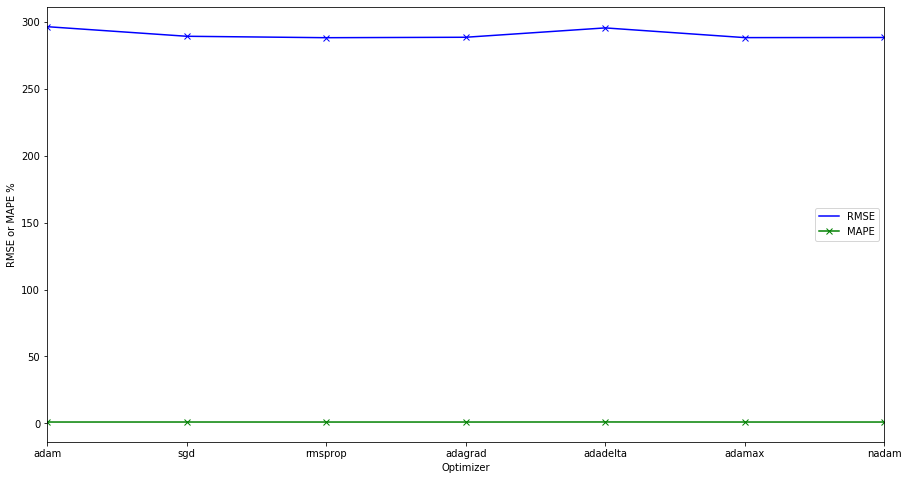

In [20]:
rcParams['figure.figsize'] = 15, 8


ax = error_rate.plot(x='optimizer', y='RMSE', style='bx-')
ax = error_rate.plot(x='optimizer', y='MAPE', style='gx-', ax=ax)
ax.set_xlabel("Optimizer")
ax.set_ylabel("RMSE or MAPE %")

temp = error_rate[error_rate['RMSE'] == error_rate['RMSE'].min()]
optimizer_param = temp['optimizer'].values[0]
print("min RMSE = %0.3f" % error_rate['RMSE'].min())
print("min MAPE = %0.3f%%" % error_rate['MAPE'].min())
print("optimum " + param_label + " = " + str(optimizer_param))

In [25]:
d = {'param': ['N', 'lstm_units', 'dropout_prob', 'optimizer', 'epochs', 'batch_size', 'rmse', 'mape_pct'],
     'init': [N, lstm_units, dropout_prob, optimizer, epochs, batch_size, rmse_bf_tuning, mape_bf_tuning],
     'after_tuning': [N_param, lstm_units_param, dropout_prob_param, optimizer_param, epochs_param, batch_size_param, error_rate['RMSE'].min(), error_rate['MAPE'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params

,param,init,after_tuning
0,N,9,6
1,lstm_units,50,10
2,dropout_prob,1,0.6
3,optimizer,adam,rmsprop
4,epochs,1,1
5,batch_size,1,128
6,rmse,608.394,288.237
7,mape_pct,1.98681,0.968201


In [26]:
# Final model data
scaler_final = StandardScaler()
train_cv_scaled_final = scaler_final.fit_transform(np.array(train_cv['XHJ']).reshape(-1,1))
print("scaler_final.mean_ = " + str(scaler_final.mean_))
print("scaler_final.var_ = " + str(scaler_final.var_))


scaler_final.mean_ = [20393.25572843]
scaler_final.var_ = [3280619.56597496]


In [30]:
x_train_cv_scaled, y_train_cv_scaled = getxy(train_cv_scaled_final, N_param, N_param)
x_test_scaled, y_test, mu_test_list, std_test_list = get_scaled_x_y(np.array(df['XHJ']).reshape(-1,1), N_param, num_train+num_cv)

rmse, mape, est = train_pred_eval_model(x_train_cv_scaled, y_train_cv_scaled, x_test_scaled, y_test, mu_test_list, std_test_list, lstm_units=lstm_units_param, dropout_prob=dropout_prob_param, optimizer=optimizer_param, epochs=epochs_param, batch_size=batch_size_param)

print("RMSE on test set = %0.3f" % rmse)
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 382.807
MAPE on test set = 1.100%


Text(0, 0.5, 'Future close return')

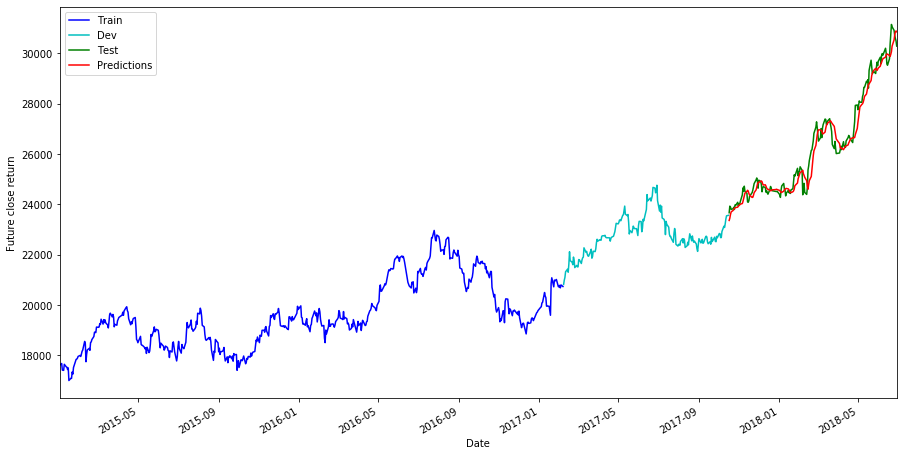

In [31]:
rcParams['figure.figsize'] = 15, 8
est_df = pd.DataFrame({'est': est.reshape(-1),
                       'Date': df[num_train+num_cv:]['Date']})

ax = train.plot(x='Date', y='XHJ', style='b-')
ax = cv.plot(x='Date', y='XHJ', style='c-', ax=ax)
ax = test.plot(x='Date', y='XHJ', style='g-', ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', ax=ax )
ax.legend(['Train', 'Dev', 'Test', 'Predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Future close return")

(22000, 32000)

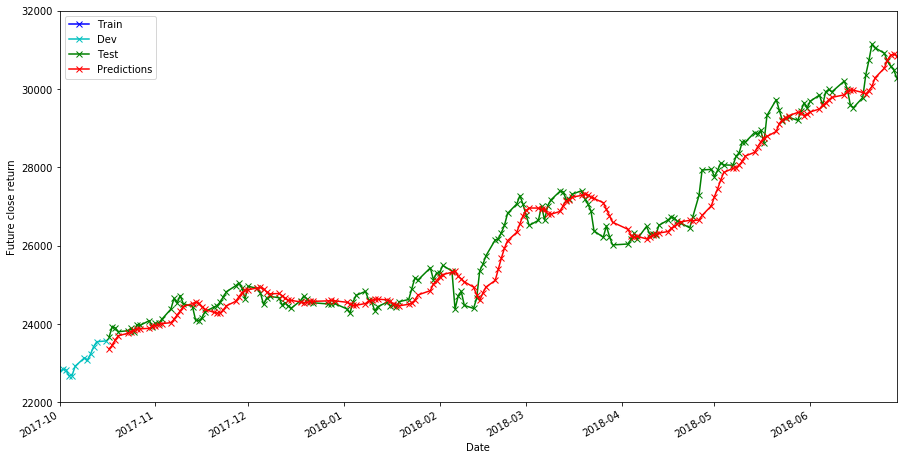

In [34]:
rcParams['figure.figsize'] = 15, 8
ax = train.plot(x='Date', y='XHJ', style='bx-')
ax = cv.plot(x='Date', y='XHJ', style='cx-', ax=ax)
ax = test.plot(x='Date', y='XHJ', style='gx-', ax=ax)
ax = est_df.plot(x='Date', y='est', style='rx-', ax=ax )
ax.legend(['Train', 'Dev', 'Test', 'Predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Future close return")
ax.set_xlim([date(2017,10,1)],[date(2018,6,29)])
ax.set_ylim([22000,32000])